## Task 1-2

In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 21 09:14:50 2017

@author: henning
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score

def loadData():
    data = pd.read_csv('campusDemand.csv', infer_datetime_format=True)
    
    pn = set(data['Point name'])
    print(pn)
    
    bdata = data.loc[data['Point name'] == 'Baker Hall Electric (Shark 29) - Demand Watts ']
    pdata = data.loc[data['Point name'] == 'Porter Hall Electric (Shark 30) - Watts']
    
    data = [bdata, pdata]
    return data

data = loadData()


def createDF(df):
    return pd.DataFrame(index = pd.to_datetime(df['Time']),
                        data = df['Value'].values, columns=['D'])
    
data = [createDF(x) for x in data]

{'Scaife Hall Electric (Shark 21) - Watts', 'University Center Electric (Shark 34) - Watts', 'Doherty Apts Electric (Shark 11) - Demand Watts', 'Baker Hall Electric (Shark 29) - Demand Watts ', 'Electric kW Calculations - Main Campus kW', 'Baker Hall Electric (Shark 29) - Watts', 'Porter Hall Electric (Shark 30) - Watts'}


## Task 3

In [33]:
def cleanData(df):
    #hard thresholding
    # any condition that introduces some kind of threshold is fine
    # in this case we prohibit values smaller than 1.5 stds
    threshold = np.mean(df['D']) - 1.5*np.std(df['D'])
    df['D'][df['D'] < threshold] = np.nan
    return df.interpolate(method='linear')

data = [cleanData(x) for x in data]

## Task 4

In [34]:
def decompose(df):
    df['Hour'] = df.index.hour
    df['Day'] = df.index.dayofyear
    df['DayOfWeek'] = df.index.dayofweek
    df = df.groupby(['Day', 'Hour']).mean().unstack().interpolate(method='linear')
    #ampltiude
    a = np.sum(df.values[1:,:24],axis=1)
    d = (df.values[1:,:24].T/a).T
    dofw = df.values[1:,25]
    #[1:] because leading nans cannot be interpolated
    #also, from now on, we are not operating on dataframes anymore
    #but (ampltitude, loadcurve, values, dayofweek)-triples
    return (a,d,df.values[1:,:24],dofw)

data = [decompose(x) for x in data]

## Task 5

[None, None]

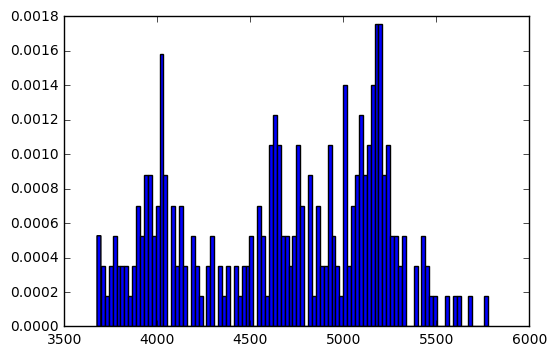

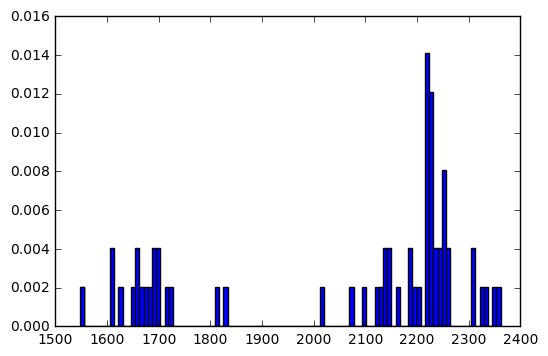

In [35]:
def dailyConsumptionDensity(a):
    plt.figure()
    plt.hist(a/1000, normed=True, bins=100)
[dailyConsumptionDensity(x[0]) for x in data]

## Task 6

[None, None]

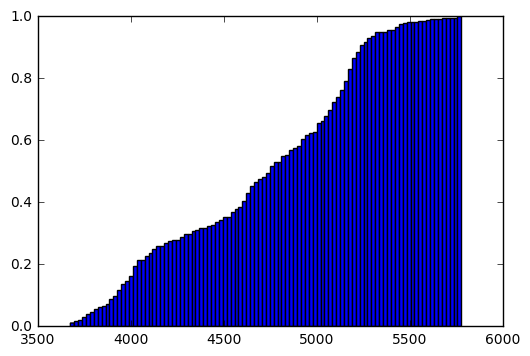

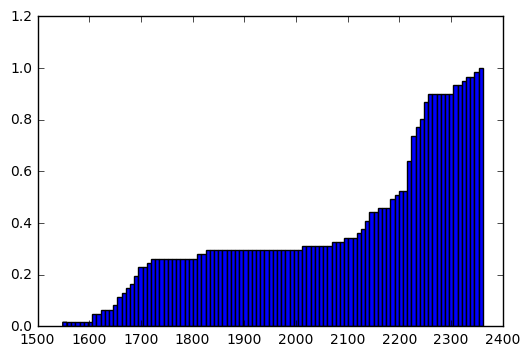

In [36]:
def dailyConsumptionCum(a):
    plt.figure()
    plt.hist(a/1000, normed=True, bins=100, cumulative=True)
[dailyConsumptionCum(x[0]) for x in data]

## Task 7/8
The data is pretty sparse, i.e. we only have roughly 200 data points, so we cannot really identify a distribution.
However, when we look at the distribution of hourly consumption instead of the distribution of daily consumption, we can see nicer patterns (below).

The first distribution seems to be generated by a log-normal distribution, i.e. a slanted Gaussian distribution with a long tail. However, the second distribution seems more like a 2-mixture of Gaussians, since the distribution seems to be bi-modal.

[None, None]

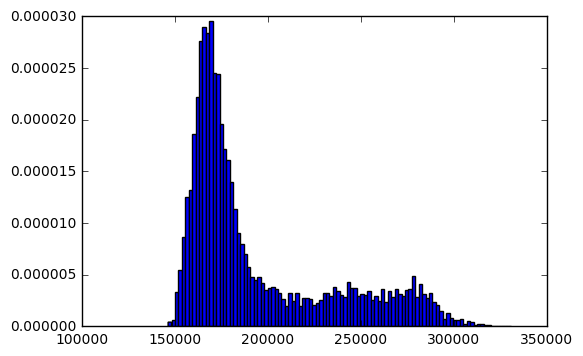

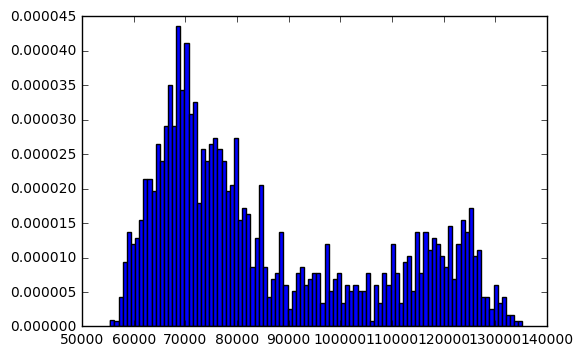

In [37]:
def hourlyConsumptionDensity(d):
    plt.figure()
    dat = np.reshape(d, (np.prod(d.shape),))
    plt.hist(dat, normed=True, bins=100)
    
def hourlyConsumptionCum(d):
    plt.figure()
    dat = np.reshape(d, (np.prod(d.shape),))
    plt.hist(dat, normed=True, bins=100, cumulative=True)
    
[hourlyConsumptionDensity(x[2]) for x in data]

## Task 9

[None, None]

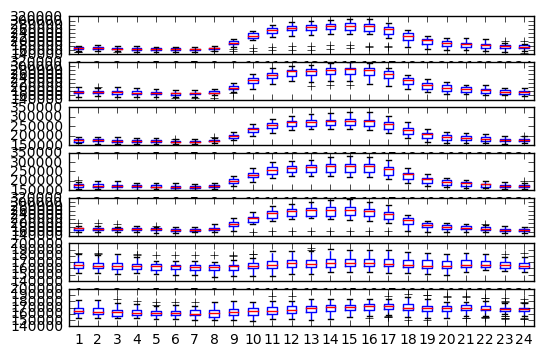

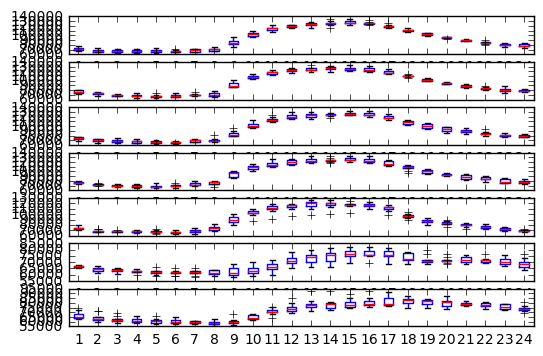

In [38]:
def plot_dailys(triple):
    vals = triple[-2]
    day = triple[-1]
    plt.figure()
    for i in range(7):
        plt.subplot(7,1,i+1)
        plt.boxplot(vals[day==i,:])
[plot_dailys(x) for x in data]

## Task 10

[None, None]

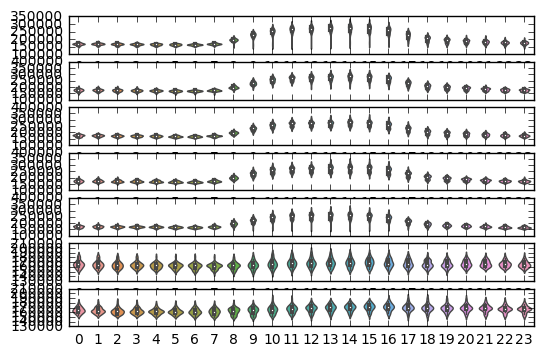

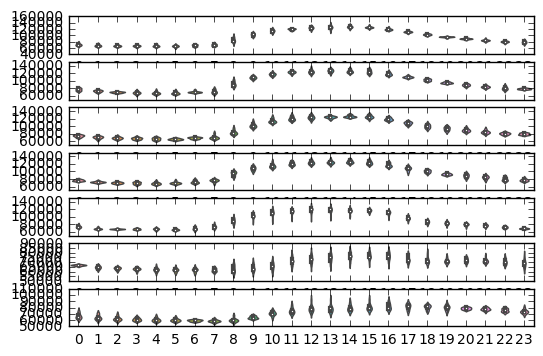

In [39]:
def plot_violin(triple):
    vals = triple[-2]
    day = triple[-1]
    plt.figure()
    for i in range(7):
        plt.subplot(7,1,i+1)
        seaborn.violinplot(data=vals[day==i,:])
[plot_violin(x) for x in data]

## Task 11

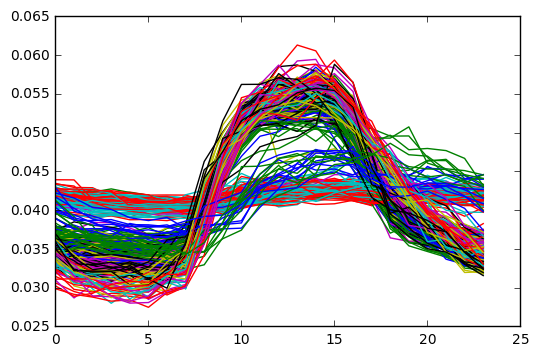

In [40]:
def plot_loadCurves_ugly(data):
    vals = np.concatenate([triple[1] for triple in data])
    plt.plot(vals.T)
plot_loadCurves_ugly(data)

## Task 12

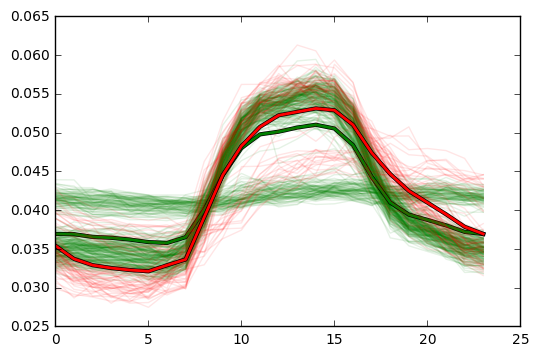

In [46]:
def plot_loadCurves_nice(data):
    for c,d in zip(['g','r'], data):
        plt.plot(d[1].T, color=c, alpha=0.1)
        plt.plot(np.mean(d[1],axis=0), color='k', alpha=1, linewidth='3')
        plt.plot(np.mean(d[1],axis=0), color=c, alpha=1, linewidth='2')
plot_loadCurves_nice(data)

## Task 13
Some observations:
* Daily patterns of both meter are pretty similar in mean
* However, weekends are clearly visible for both meters, on top of that, weekend patterns differ:
* * flat green lines -> building probably unoccupied
* * phase shifted red lines -> people seem to arrive and leave later

## Task 14/15

In [42]:
def computeScatter(data, cluster_assign=None):
    num_curves = len(data[0][1]) + len(data[1][1])
    num_first = len(data[0][1])
    all_vals = np.concatenate([triple[1] for triple in data])
    
    #when no cluster assignment is provided, we assume meter-clustering
    if type(cluster_assign)==type(None):
        cluster_assign = np.zeros((num_curves,))
        cluster_assign[:num_first] = 1
    
    T = 0
    W = 0
    B = 0
    for i in range(num_curves):
        for j in range(num_curves):
            d = np.linalg.norm(all_vals[i,:]-all_vals[j,:])
            T+=d
            if cluster_assign[j] == cluster_assign[i]:
                #both load curves belong to same cluster
                W+=d
            else:
                B+=d
                
    return T,W,B

T,W,B = computeScatter(data)
print('T',T,'B',B,'W',W,)

T 2415.27190478 B 829.768225018 W 1585.50367976


## Task 16

In [43]:
def random_cluster(data):
    num_curves = len(data[0][1]) + len(data[1][1])
    num_clusters = [3,5,10]
    
    for n in num_clusters:
        cluster_assign = np.random.choice(np.arange(n), (num_curves,))
        print(computeScatter(data,cluster_assign))
random_cluster(data)

(2415.271904778418, 807.47505200423711, 1607.7968527741498)
(2415.271904778418, 486.60545997658659, 1928.6664448018123)
(2415.271904778418, 240.48090580991007, 2174.7909989685154)


## Task 17
We use two different 'features', i.e. the normalized load curves according to equation (1) of Kwarc and the unnormalized load curves. We try to tell three things from the clusters, i.e. the meter, day of the week and wether or not it is a weekend day.
As a metric for how well we are doing, we use mutual information. Below are the scores for the resulting 6 settings.

In [44]:
def kMean_find(data):
    norm_curves = np.concatenate([triple[1] for triple in data])
    curves = np.concatenate([triple[2] for triple in data])
    
    #The ground truth:
    meter_assign = np.zeros((len(curves),))
    meter_assign[:len(data[0][1])] = 1
    dayweek_assign = np.concatenate([triple[-1] for triple in data])
    weekend_assign = dayweek_assign>4
    
    ## Let's try to seperate the two meters from (normalized) load curves
    k = KMeans(n_clusters=2)
    assign = k.fit_predict(norm_curves)
    print('NormCurv -> Meter: MI', mutual_info_score(meter_assign, assign))
    print('NormCurv -> weekend: MI', mutual_info_score(weekend_assign, assign))
    k = KMeans(n_clusters=7)
    assign = k.fit_predict(norm_curves)
    print('NormCurv -> DayOfWeek: MI', mutual_info_score(dayweek_assign, assign))

    k = KMeans(n_clusters=2)
    assign = k.fit_predict(curves)
    print('Curv -> Meter: MI', mutual_info_score(meter_assign, assign))
    print('Curv -> weekend: MI', mutual_info_score(weekend_assign, assign))
    k = KMeans(n_clusters=7)
    assign = k.fit_predict(curves)
    print('Curv -> DayOfWeek: MI', mutual_info_score(dayweek_assign, assign))
    

kMean_find(data)

NormCurv -> Meter: MI 5.21240688076e-06
NormCurv -> weekend: MI 0.560902034328
NormCurv -> DayOfWeek: MI 0.653649754862
Curv -> Meter: MI 0.477009950323
Curv -> weekend: MI 1.91647522052e-05
Curv -> DayOfWeek: MI 0.605283854973
